In [1]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## DropValues 
### Input:
    df              <DataFrame> to drop values from.
    Percentage      <float> Percentage of values to drop from the DataFrame.

### Returns:
    temp            <DataFrame> containing NaN values for dropped values.
    NAMask          <DataFrame> containing True for dropped values of temp DataFrame.

### Description:
The function DropValues() makes a certain percentage of the data NaN.

In [2]:
def DropValues(df,Percentage):
    
    NAMask = pd.DataFrame(data=np.random.uniform(low=0, high=1, size=df.shape) > Percentage)
    temp = df.copy()
    for i in range(len(temp.index)):
        for o in range(len(temp.columns)):
            if not NAMask.iloc[i,o]:
                temp.iloc[i,o] = np.nan
    return temp

## Data Generation Function
### Input:
    size            <list> [Columns<int>, Index<int>]
    m               <int> What rank matrix will the dataset be?
    sigma_err       <float> What normal error should the final dataset contain? 
                    (based on a standard normally distributed random float)
                    
    
### Returns:
    X_gen           <DataFrame> Generated Dataset with errors
    
### Description:
The function GenerateData() creates a dataset of size _size_. This generator simulates real world data. This generator also applies a standard normally distributed error defined by _sigma_err_.

#### Steps:
    Step 1: Generate DataFrames C_true and D_true. These are of size n x m and p x m respectively. 
    These DataFrames are filled with standard normally distributed values.
    
    Step 2: Subtract the mean from each C_true Column to not model the mean when using PCA
    
    Step 3: Generate DataFrame X_true. This DataFrame contains the dot product of C_true and D_true.
    
    Step 4: Create error and correct for mean per Column.
    
    Step 5: Add error * sigma_err to generated DataFrame
    
    Step 6: ....Profit?! (actually you now have a dataset that simulates real world data, but profit also works)


In [3]:
def GenerateData(size,m=2,sigma_err=0.05, debug = True):
    if debug:
        print("Now generating a rank %i matrix of size %i x %i with an error of %f"%(m, size[0], size[1], sigma_err))
    
    #Generates Matrix C_true with size n x m with standard normally distributed values
    C_true = pd.DataFrame(data=np.random.randn(size[0],m))

    #This makes it so we don't model the mean when using PCA
    C_true = C_true - np.outer(np.full((size[0],1), 1),C_true.mean())
    #Generates Matrix D_true with size p x m with standard normally distributed values
    D_true = pd.DataFrame(data=np.random.randn(size[1],m))

    #Generate true Matrix X using C_true and D_true'
    X_true = pd.DataFrame(data=np.dot(C_true,D_true.transpose()))

    #Add real world errors
    E = pd.DataFrame(data=np.random.randn(size[0],size[1]))

    E = E - np.outer(np.full((size[0],1), 1),E.mean())

    X_gen = X_true + sigma_err * E
    
    return X_gen

    ##Singular Value Decomposition of X_gen
    #svd = np.linalg.svd(X_gen,full_matrices=False)

    ##Reconstruction of X_gen
    #X_gen_r = np.dot(svd[0][:,:m] * svd[1][:m], svd[2][:m,:])

## PCA Iterative Model

### Input:
    X_missings      <list>[Columns<int>, Index<int>]
    m               (optional, default = 2) <int> What rank matrix will the dataset be?
    max_iter        (optional, default = 1000) <int> The maximum amount of iterations PCA should execute.
    exitPower       (optional, default = -6) <int> When the RSS is less than 10 ** exitPower, the model will consider itself trained.
    debug           (optional, default = False) <boolean> Display debug info RSS debug info. 
                    
    
### Returns:
    Xem_rec         <DataFrame> Recreated dataset without missings.
    

### Description:
This method uses Singular Value Decomposition (SVD) to recreate missing datapoints in a few simple steps.

### Steps (really boiled down version of it):
    Step 1: Decompose DataFrame X_missings where NaN is replaced with 0 using SVD.
    
    Step 2: Reconstruct a new DataFrame based on the values from step 1.
    
    Step 3: Replace missing spots with reconstructed data.
    
    Step 4: Calculate RSS.
    
    Step 5: If the difference between RSS and the RSS of the previous iteration is smaller than 10 ** exitPower, return the generated dataset.
    
    Step 6: If this difference is not larger than 10 ** exitPower, redo the previous steps on the new dataset. This method keeps correcting the known values to its originals, thus getting the error closer and closer to 0.
    

In [4]:
def PCAMiss(X_missings, m = 2, maxIter = 1000, debug = False, exitPower = -6):
    n = X_missings.index
    p = X_missings.columns
    
    Xem = X_missings.copy().fillna(0)
    Miss = X_missings.copy().isin([np.nan])
    
    #Calculate Sum-of-Squares
    SSQ = np.nansum((X_missings) ** 2)
    lastRSS = 1
    if debug:
        print("Now iterating over NaN filled matrix using PCA.\n")
    
    for i in range(maxIter):
        svd = np.linalg.svd(Xem, full_matrices=False)
        Xem_rec = np.dot(svd[0][:,:m] * svd[1][:m], svd[2][:m,:])
        Xem = (1 - Miss) * Xem + Miss * Xem_rec
        
        #Calculate Residual Sum-of-Squares
        RSS = np.nansum((X_missings - Xem_rec) ** 2) / SSQ
        
        if debug:
            print("Iteration %i: RSS = %.8f, difference = %.8f"%(i, RSS, lastRSS - RSS))
        
        #Exit Condition
        if (lastRSS-RSS) < (10 ** exitPower):
            if debug:
                print("\nFound acceptable solution within %i iterations!"%(i))
            return pd.DataFrame(data=Xem_rec)
        lastRSS = RSS
    print("\n\n\nError: Reached end of max iterations without converging to successful model.")

# Start of actual model

In [13]:
#Setting random state of Python. This is for reproducibility.
np.random.seed(42)

#How many profiles?
#profiles = int(input("Amount of profiles: "))
profiles = 100
#m = int(input("Dimensions: "))
m = 6
#missPercent = float(input("Enter missings Percentage: "))/100
missPercent = 0.50
#Getting column names of recipes
ColumnNames = pd.read_csv("../Generated Datasets/ingr_pivot_lunch_diner_noten.csv")["recipe"]

#Dataset variables.
size = [profiles,len(ColumnNames)] #Size

#Generates Dataset using a rank 2 matrix.
X_gen = GenerateData(size, m = m)

#Pokes holes in the dataset where missPercent of the original matrix dropped.
X_missing = DropValues(X_gen, missPercent)

#Trains and fits model
X_pred = PCAMiss(X_missing, m = m, maxIter = 1000, exitPower = -6, debug = True)

#Apply column names to X_pred
X_pred.columns = list(ColumnNames)
X_pred.index.name = "Users"
X_gen.columns = list(ColumnNames)
X_gen.index.name = "Users"

Now generating a rank 6 matrix of size 100 x 4616 with an error of 0.050000
Now iterating over NaN filled matrix using PCA.

Iteration 0: RSS = 0.22926422, difference = 0.77073578
Iteration 1: RSS = 0.06994645, difference = 0.15931778
Iteration 2: RSS = 0.02562861, difference = 0.04431784
Iteration 3: RSS = 0.01077565, difference = 0.01485295
Iteration 4: RSS = 0.00508103, difference = 0.00569463
Iteration 5: RSS = 0.00266355, difference = 0.00241748
Iteration 6: RSS = 0.00155312, difference = 0.00111043
Iteration 7: RSS = 0.00101058, difference = 0.00054254
Iteration 8: RSS = 0.00073223, difference = 0.00027835
Iteration 9: RSS = 0.00058370, difference = 0.00014852
Iteration 10: RSS = 0.00050188, difference = 0.00008182
Iteration 11: RSS = 0.00045560, difference = 0.00004628
Iteration 12: RSS = 0.00042882, difference = 0.00002677
Iteration 13: RSS = 0.00041304, difference = 0.00001578
Iteration 14: RSS = 0.00040358, difference = 0.00000946
Iteration 15: RSS = 0.00039782, difference = 

## Boxplot of the difference between the generated dataset and the predicted dataset

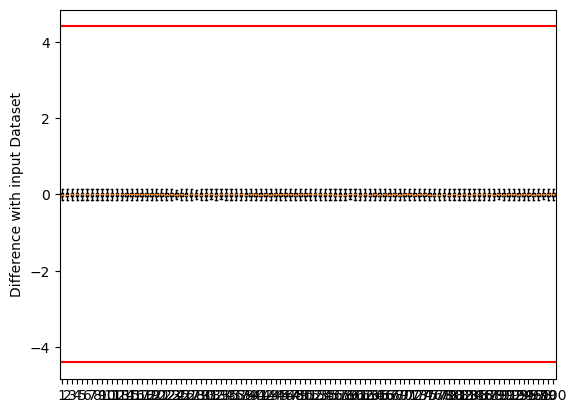

In [6]:
fig, ax = plt.subplots()
VP = ax.boxplot((X_gen-X_pred).to_numpy().transpose(), showfliers=False)
flattenedX_gen = np.std(X_gen.to_numpy().flatten())
plt.axhline(y = flattenedX_gen, color = 'r', linestyle = '-')
plt.axhline(y = -flattenedX_gen, color = 'r', linestyle = '-')
ax.set_ylabel("Difference with input Dataset")
plt.show()

In [14]:
X_pred.to_csv("PCADataset.csv")

In [8]:
X_gen

,Andijviestamppot met gebakken salami,Libanese wraps met appel-koolsalade,Plaattaart met gegrilde groenten en witte kaas,Zalmspies met sojaglaze van de BBQ,&amp;Suus’ buik-weg-salade,'Burrito'-schotel met knapperige tortillapuntjes,'Foeyonghai' met bami,'Kapsalon' met&nbsp;vegetarische&nbsp;kipshoarma en salade,'Leeuwenkoppen' van gehakt en kool,'Marokkaanse' lamsbout,...,Zwarte-bonenstoof met feta,Zwartebonen-rijstsalade met avocado &amp; witte kaas,Zwartebonenchili met kip,Zwartebonenstoof met tofu en gordita's,Zweedse balletjes,Zweedse gehaktballetjes,Zweedse gehaktballetjes met room,Zweedse vegaballetjes met aardappel &amp; broccoli,Zwitserse kaasfondue,‘Nasi’ met Hollandse soepgroente
Users,,,,,,,,,,,,,,,,,,,,,
0,1.168735,1.073999,3.732978,-3.503076,-4.808716,5.033530,2.564946,-3.793279,-1.299513,3.430405,...,3.480099,1.013049,-8.242541,-5.775872,-4.019913,-1.588838,-3.055362,11.113857,-4.826622,-5.314768
1,3.974292,-2.231107,-3.969005,1.692700,10.332330,9.282484,2.449239,4.125063,-11.321488,6.240695,...,-4.467167,-3.704572,-0.638693,-1.002180,-1.530703,-1.389050,3.880317,-2.369540,3.137744,7.039607
2,0.506345,8.730859,-1.047864,-2.258410,-0.282077,-0.279282,-1.412039,1.167983,-1.017320,-2.472675,...,-1.875081,0.731492,0.197727,3.384073,1.287204,4.410680,1.317953,-2.135142,4.962649,6.124718
3,-3.036842,2.422893,2.562667,2.802212,-4.773434,-2.567192,4.337841,6.522905,1.199882,-5.632431,...,4.949970,-2.139736,-5.465281,-0.422323,4.510113,-5.678428,-0.477381,6.866531,5.222472,-2.251486
4,0.255255,1.697374,1.470726,0.051503,0.215265,-1.652576,-0.372453,-0.116102,-4.139772,-0.490851,...,-0.685006,-2.541163,-5.459858,-0.157574,3.542638,2.607865,-2.023399,-4.274947,-2.710666,1.144505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-5.599942,-5.486592,2.099518,7.776908,-2.486769,0.906361,3.247119,10.898665,4.997821,2.895660,...,-3.619992,-5.707737,-4.168577,-8.036493,-2.777894,-5.254000,-3.287583,4.884654,2.020557,2.386440
96,5.048570,-16.854190,-3.591459,6.894394,5.345182,-0.843851,-1.941398,-1.161495,4.779393,1.533898,...,-0.455256,5.651362,0.679556,-4.671623,0.200929,-7.627416,4.272494,-15.850104,1.564520,-0.901140
97,-3.433305,-3.261572,0.905431,2.966825,-7.623563,-7.012228,0.863580,2.387332,7.886392,-3.192664,...,9.545841,7.724157,-4.085003,-8.227428,-4.312337,-2.393876,-0.006966,5.604834,3.332366,4.327716
